/tmp/ipython-input-241521023.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.colormaps.get("tab10", plt.cm.get_cmap("tab10"))


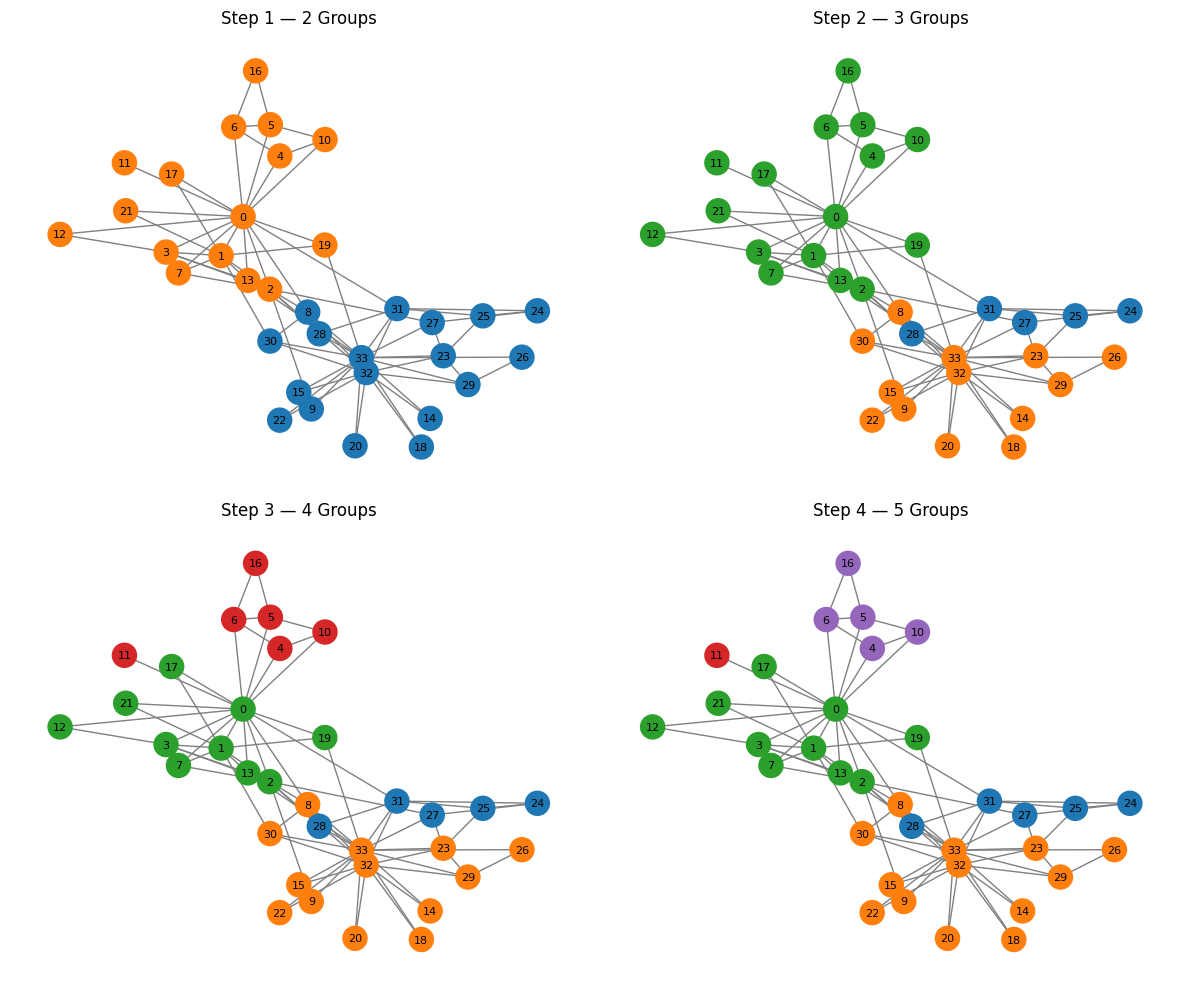

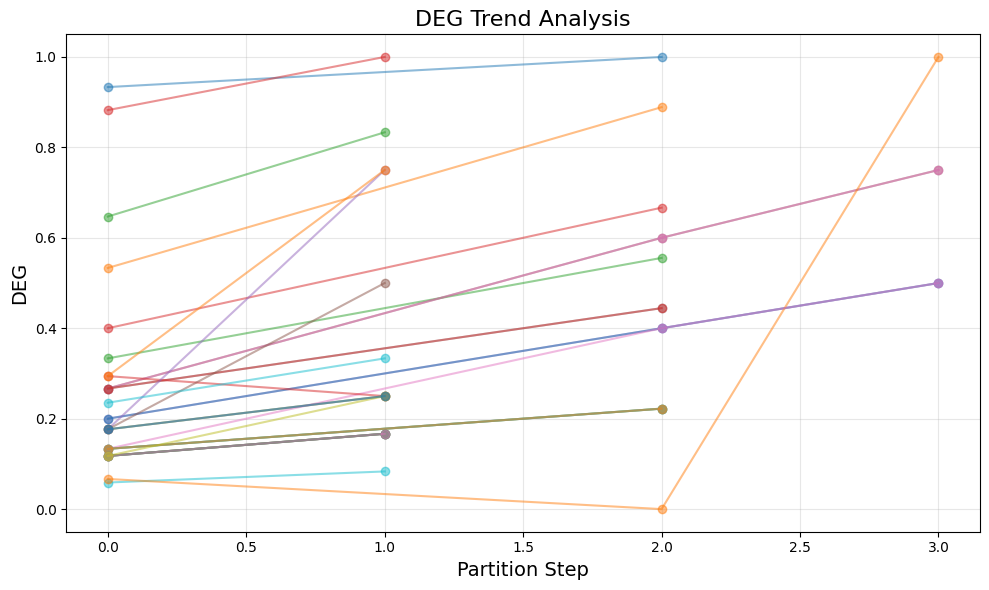

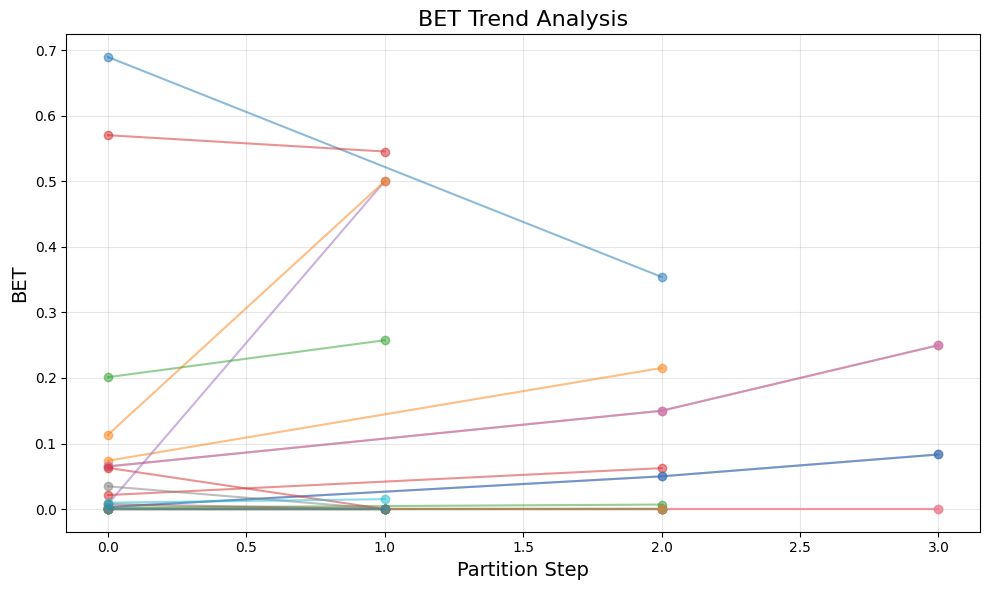

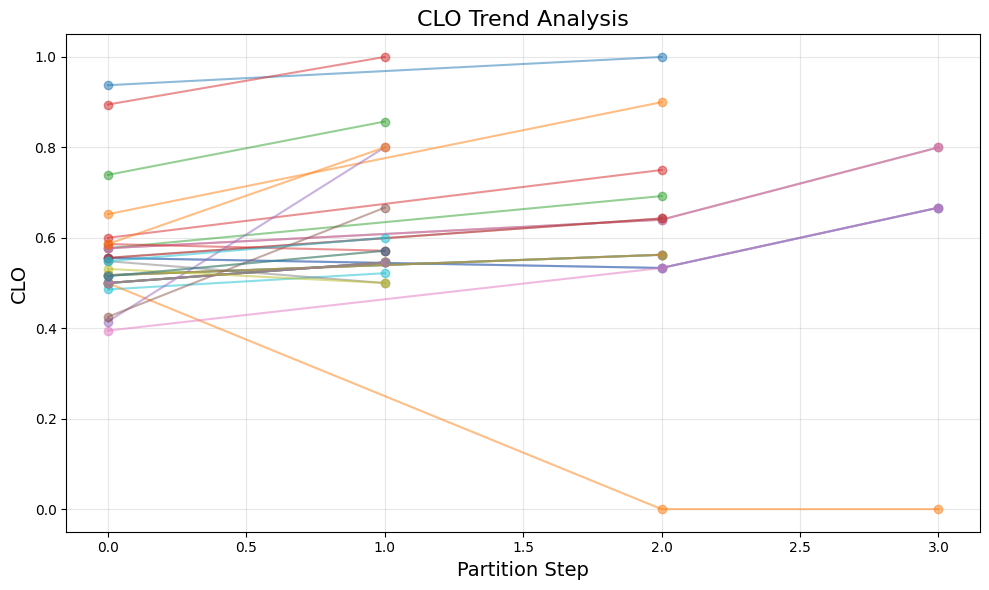

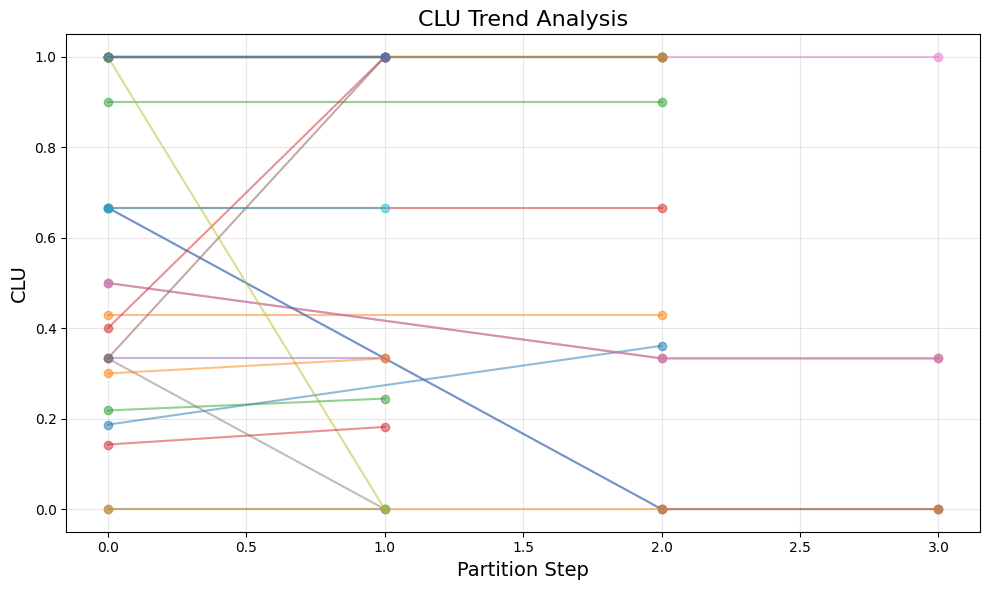

In [8]:
import networkx as nx
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

network_obj = nx.karate_club_graph()
A_mat = nx.to_numpy_array(network_obj, weight=None)
k_vec = np.array(network_obj.degree())[:, 1]
m_val = np.sum(k_vec) / 2.0
expected_A = np.outer(k_vec, k_vec.T) / (2.0 * m_val)
B_mat = A_mat - expected_A

def get_topology_stats(graph_segment):
    d_cent = nx.degree_centrality(graph_segment)
    b_cent = nx.betweenness_centrality(graph_segment)
    c_cent = nx.closeness_centrality(graph_segment)
    clust_coef = nx.clustering(graph_segment)
    return {
        "deg": d_cent,
        "bet": b_cent,
        "clo": c_cent,
        "clu": clust_coef
    }

def spectral_partitioning(active_subgraph, tree_structure=None, attribute_tracker=None):
    if tree_structure is None:
        tree_structure = []

    if attribute_tracker is None:
        attribute_tracker = []

    node_subset = list(active_subgraph.nodes)

    if len(node_subset) <= 1:
        tree_structure.append([node_subset])
        return tree_structure

    B_sub = B_mat[np.ix_(node_subset, node_subset)]
    evals, evecs = eigh(B_sub)
    u1_vec = evecs[:, -1]
    lambda_max = evals[-1]

    partition_vector = np.where(u1_vec > 0, 1, -1)

    set_alpha = [node_subset[i] for i in range(len(node_subset)) if partition_vector[i] == 1]
    set_beta = [node_subset[i] for i in range(len(node_subset)) if partition_vector[i] == -1]

    if lambda_max <= 0 or len(set_alpha) == 0 or len(set_beta) == 0:
        tree_structure.append([node_subset])
        return tree_structure

    tree_structure.append([set_alpha, set_beta])

    step_attributes = {
        "alpha_branch": get_topology_stats(active_subgraph.subgraph(set_alpha)),
        "beta_branch": get_topology_stats(active_subgraph.subgraph(set_beta)),
    }
    attribute_tracker.append(step_attributes)

    spectral_partitioning(active_subgraph.subgraph(set_alpha), tree_structure, attribute_tracker)
    spectral_partitioning(active_subgraph.subgraph(set_beta), tree_structure, attribute_tracker)

    return tree_structure, attribute_tracker

partition_results, stats_history = spectral_partitioning(network_obj)

def draw_partition_steps(base_graph, hierarchy_list):
    fixed_pos = nx.spring_layout(base_graph, seed=42)
    active_groups = [list(base_graph.nodes)]
    binary_splits = [item for item in hierarchy_list if len(item) == 2 and len(item[0]) > 0 and len(item[1]) > 0]

    if not binary_splits:
        print("No splits to visualize")
        return

    count_splits = len(binary_splits)
    cols = 2
    rows = (count_splits + cols - 1) // cols

    fig, ax_array = plt.subplots(rows, cols, figsize=(12, 5*rows))
    ax_array = np.atleast_1d(ax_array).flatten()

    palette = plt.colormaps.get("tab10", plt.cm.get_cmap("tab10"))

    for level, split_pair in enumerate(binary_splits):
        upcoming_groups = []
        merged_indices = set(split_pair[0]) | set(split_pair[1])

        for grp in active_groups:
            if set(grp) == merged_indices:
                upcoming_groups.extend([split_pair[0], split_pair[1]])
            else:
                upcoming_groups.append(grp)

        active_groups = upcoming_groups

        node_colors = []
        for n in base_graph.nodes():
            for idx, g in enumerate(active_groups):
                if n in g:
                    node_colors.append(palette(idx % 10))
                    break

        nx.draw_networkx(
            base_graph,
            pos=fixed_pos,
            ax=ax_array[level],
            with_labels=True,
            node_color=node_colors,
            edge_color="gray",
            font_size=8,
            node_size=300
        )

        ax_array[level].set_title(f"Step {level+1} — {len(active_groups)} Groups", fontsize=12)
        ax_array[level].axis("off")

    for axis in ax_array[count_splits:]:
        axis.axis("off")

    plt.tight_layout()
    plt.show()

def graph_metric_changes(tracker_data):
    keys_to_plot = ["deg", "bet", "clo", "clu"]

    nodes_involved = {
        n
        for record in tracker_data
        for branch in ["alpha_branch", "beta_branch"] if branch in record
        for inner_dict in record[branch].values()
        for n in inner_dict.keys()
    }

    for key in keys_to_plot:
        plt.figure(figsize=(10, 6))

        for n_id in sorted(nodes_involved):
            x_vals = []
            y_vals = []

            for idx, record in enumerate(tracker_data):
                found_val = next(
                    (record[branch][key].get(n_id)
                     for branch in ["alpha_branch", "beta_branch"]
                     if branch in record and n_id in record[branch][key]),
                    None
                )
                if found_val is not None:
                    x_vals.append(idx)
                    y_vals.append(found_val)

            if y_vals:
                plt.plot(x_vals, y_vals, marker="o", label=f"ID {n_id}", alpha=0.5)

        plt.title(f"{key.upper()} Trend Analysis", fontsize=16)
        plt.xlabel("Partition Step", fontsize=14)
        plt.ylabel(key.upper(), fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

draw_partition_steps(network_obj, partition_results)
graph_metric_changes(stats_history)